In [6]:
%%capture
from IPython.display import display, Math, Latex
%pylab inline

`%matplotlib` prevents importing * from pylab and numpy


In [13]:
%%capture
%run parameter_sampling_planck2015.py

Now we want to apply a Metropolis-Hastings MCMC to sample parameters for a given power spectrum. 

For a data set $d = As+n$, where n is noise, A is the signal and A is the beam.

Here we produce our own "data set" d: 
- we generate a spectrum $C_\ell$ from a set of parameters (here ~Planck 2015)
- we generate $a_{\ell m}$ using healpy $\texttt{synalm}$
- we apply a 5 arcmin FWMH gaussian beam $b_\ell$ 
- we add a white noise in $a_{\ell m}$ space


This step is only done once. 



Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


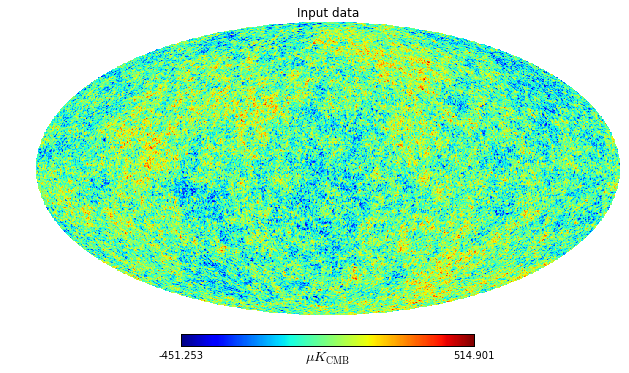

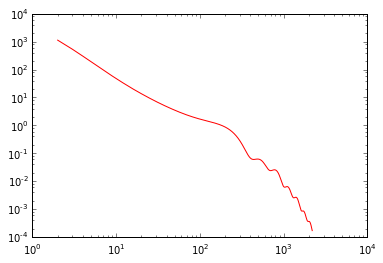

In [3]:
a = plot_input(dlm)

Then we use a Metropolis-Hastings algorithm:
- we generate a random set of parameters $\Omega_0$.
- The target distribution is given by: 
\begin{equation}
\Pi(\Omega \vert d)=\frac{e^{-\frac{1}{2} d (\;A S(\Omega)A^T + N\;)^{-1} d^T} }{\sqrt{2\pi \; \vert \; A S(\Omega)A^T + N \; \vert }} \;. 
\end{equation}
Though I am not sure I understand where it comes from.
- The proposal distribution is:
\begin{equation}
w(\Omega_{i+1}\vert \Omega_i)=\frac{e^{-\frac{1}{2} (\Omega_{i+1}- \Omega_{i})^{T} B^{-1}(\Omega_{i+1}- \Omega_{i})}}{\sqrt{2\pi \vert \; B \; \vert }} \;,
\end{equation}
where B is the covariance matrix, calculated using the correlation matrix from figure 42 of the likelihood paper: http://xxx.lanl.gov/pdf/1507.02704v1.pdf. It is shown in next item, along with the triangle plots.
- We then generate a random vector $u$ drawn from the gaussian of covariance $B$, centered on zero, and $\Omega_{i+1} = \Omega_i + u$.
- Since in $\Pi(\Omega_i \vert d)$, we handle some huge numbers, we will work with its logarithm. Then we compute:
\begin{equation}
A = min \left[0,log(\Pi(\Omega_{i+1} \vert d))- log(\Pi(\Omega_{i} \vert d)) +log(w(\Omega_{i}\vert \Omega_{i+1}) -  log(w(\Omega_{i+1}\vert \Omega_i)\right] \;,
\end{equation}
where here actually, the proposal being symmetric, we only need $\Pi$.
- if $A=0$, we accept.
If $A<0$, we generate a random uniform number u: if $log(u)<A$, we accept, other was we refuse the step.



#Problems

-- My issue is that doing so, I reject most of the steps. A is varying so much and get to really big negative values that are never generated by log(u).

#Implementation: 

The target distribution is calculated using:
\begin{equation}
\log (P(C,s\vert d)) = -1/2 d_{\ell m}^T (\;A S(\Omega)A^T + N\;)^{-1} d_{\ell m} - 1/2 \log(\vert  A S(\Omega)A^T + N\vert)\;,
\end{equation}
with 

\begin{equation}
S(\Omega) = \left(\begin{smallmatrix} C_2 & 0 & 0 & 0 &0 \\ 0 & C_2 & 0 & 0 & 0 \\ 0 & 0 & C_3 & 0 & 0 \\ 0 & 0 & 0 & C_3 & 0 \\ 0 & 0 & 0 & 0 & \ddots \end{smallmatrix} \right) \;, 
\end{equation}

Then: 

\begin{equation}
(\;A S(\Omega)A^T + N\;)^{-1} d_{\ell m} = (n_{\ell}+C_\ell b_\ell^2)^{-1} \ast d_{\ell m}\;,
\end{equation}

"$\ast$" computed using $\texttt{hp.almxfl}$, and :

\begin{equation}
\log(\vert  A S(\Omega)A^T + N\vert) = \sum_2^{\ell_{max}} (\ell +1 ) \log(n_{\ell}+C_\ell b_\ell^2)\;.
\end{equation}

$\textit{We don't show monopole and dipole in these equations, but healpix functions need it, so we set $C_0$ and $C_1$ to zero.}$

The different terms are shown below.


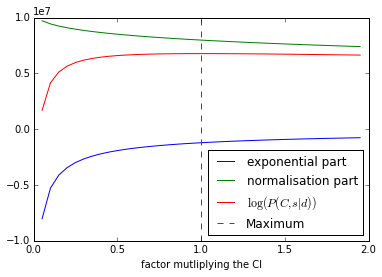

In [23]:
term_det=[]
term_exp=[]
for i in range(1,40):
    a = test_loglike(dlm,Cl*(i/20.),nl,bl)
    term_exp.append(a[0])
    term_det.append(a[1])

plt.figure()    
plt.plot(np.arange(1,40)/20.,term_exp, label="exponential part")
plt.plot(np.arange(1,40)/20.,term_det, label="normalisation part")

plt.plot(np.arange(1,40)/20.,np.array(term_exp)+np.array(term_det), label="$\log (P(C,s | d))$")
plt.xlabel("factor mutliplying the Cl")

plt.axvline((np.arange(1,40)/20.)[np.argmax(np.array(term_exp)+np.array(term_det))],ls = '--',color = "r",label="Maximum")
plt.legend(loc = 'best')



1.0

([<matplotlib.text.Text at 0x10a838d10>,
 <matplotlib.colorbar.Colorbar instance at 0x10abdcdd0>)

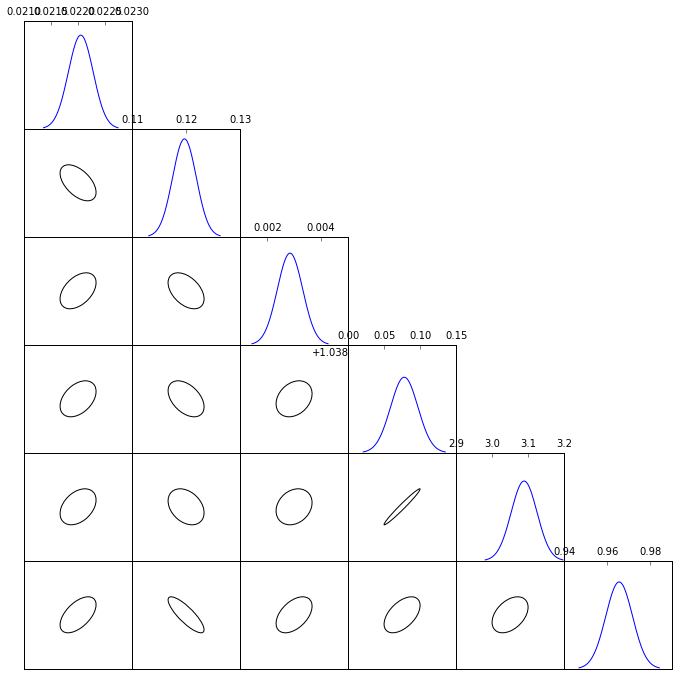

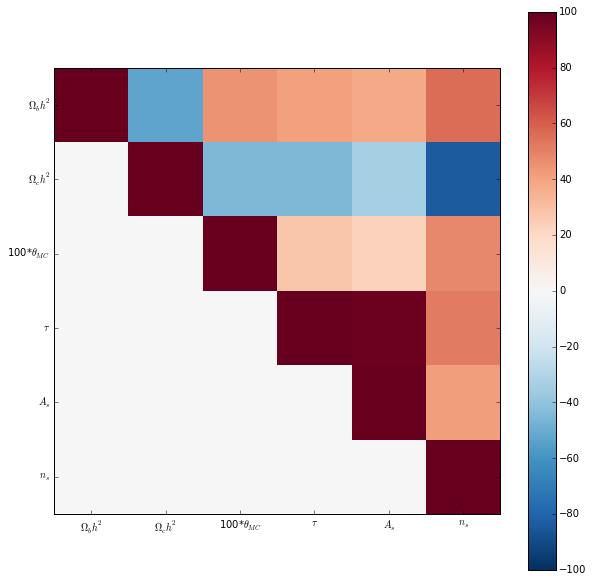

In [4]:
plt.figure(figsize=(10,10));axS,axh = plp.Triangle_plot_Cov(cov_new,x_mean)
plt.figure(figsize=(10,10)),imshow(Correlation_matrix,interpolation="nearest",cmap='RdBu_r',vmin=-100,vmax=100)
ax=plt.gca()
ax.set_xticklabels([""]+titles),ax.set_yticklabels([""]+titles),plt.colorbar()